In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_curve
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

Flat Domain adaptation, one dataset is held out, the model is trained on the remaining four datasets. Prediction is done using the parameters of the dataset that is closest to the held out one.

In [2]:
TRAIN_DIRECTORY = "../../../Data/with_Improved_Target/With_Demographics/"
# TEST_DIRECTORY = "../../../Data/Symptoms/Test/"
coefficients = defaultdict()

In [3]:
def read_file(filename):
    return pd.read_csv(filename)

def get_training_data(files_,training_directory = TRAIN_DIRECTORY):
    data = defaultdict()
    columns = defaultdict()
    for i in files_:
        name = i
        name = name.replace('.csv','')
        data[name] = read_file(training_directory+i)
        columns[name] = list(data[name].columns)
        columns[name].remove('virus')
    return data,columns

In [4]:
def overlap_columns(columns_):
    all_columns = list(columns_.values())
    overlap = list(set(all_columns[0]) & set(all_columns[1]) & set(all_columns[2]) & set(all_columns[3]))
    return overlap
    

In [5]:
def create_columns(columns_):
    overlap = overlap_columns(columns_)
    new_columns = []
    temp = []
    for i in columns_.keys():
        x = [i.replace('.csv','')+'_'+j for j in columns_[i]]
        temp.append(x)
    t = [val for sublist in temp for val in sublist]
    new_columns = t + overlap
    new_columns.append('virus')
    return new_columns

In [6]:
def create_new_dataframe(data,columns):
    new_columns = create_columns(columns)
    new_dataset = defaultdict()
    for i,name in enumerate(data.keys()):
        new_data = pd.DataFrame(columns=new_columns)
        dataset = data[name]
        for j in columns[name]:
            new_data[name+'_'+j] = dataset[j]
            new_data[j] = dataset[j]
        new_data['virus'] = dataset['virus']
        new_data.fillna(0,inplace=True)
        new_dataset[name] = new_data
    #concatenate all the dataframe
    new_dataset = pd.concat(new_dataset.values())
    return new_dataset

In [7]:
def ml_model(dataset):
    lm = linear_model.LogisticRegression()
    x_train = dataset.drop(['virus'],axis = 1)
    y_train = dataset['virus']
    x = lm.fit(x_train,y_train)
    coeff = x.coef_.tolist()[0]
    return lm,coeff

#### Heldout dataset : NYUMC

In [8]:
files_nyumc = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_nyumc,columns_nyumc = get_training_data(files_nyumc)

#create the dataframe for domain adaptation
new_dataset_nyumc = create_new_dataframe(data_nyumc,columns_nyumc)

coeff_without_nyumc = ml_model(new_dataset_nyumc)
coefficients['nyumc'] = coeff_without_nyumc

#### Heldout dataset : Goviral

In [9]:
files_goviral = ['nyumc.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_goviral,columns_goviral = get_training_data(files_goviral)
new_dataset_goviral = create_new_dataframe(data_goviral,columns_goviral)

coeff_without_goviral = ml_model(new_dataset_goviral)
coefficients['goviral'] = coeff_without_goviral

#### Heldout dataset : FluWatch

In [10]:
files_fluwatch = ['nyumc.csv','goviral.csv','hongkong.csv','hutterite.csv']
data_fluwatch,columns_fluwatch = get_training_data(files_fluwatch)
new_dataset_fluwatch = create_new_dataframe(data_fluwatch,columns_fluwatch)

coeff_without_fluwatch = ml_model(new_dataset_fluwatch)
coefficients['fluwatch'] = coeff_without_fluwatch

#### Heldout dataset : HongKong

In [11]:
files_hongkong = ['nyumc.csv','goviral.csv','fluwatch.csv','hutterite.csv']
data_hongkong,columns_hongkong = get_training_data(files_hongkong)
new_dataset_hongkong = create_new_dataframe(data_hongkong,columns_hongkong)

coeff_without_hongkong = ml_model(new_dataset_hongkong)
coefficients['hongkong'] = coeff_without_hongkong

#### Heldout dataset : Hutterite

In [12]:
files_hutterite = ['nyumc.csv','goviral.csv','fluwatch.csv','hongkong.csv']
data_hutterite,columns_hutterite = get_training_data(files_hutterite)
new_dataset_hutterite = create_new_dataframe(data_hutterite,columns_hutterite)

coeff_without_hutterite = ml_model(new_dataset_hutterite)
coefficients['hutterite'] = coeff_without_hutterite

#### Model for testing the performance

In [13]:
def test_model(train_data,test_data):
    lm,coeff = ml_model(train_data)
    train = test_data.drop(['virus'],axis = 1)
    test = test_data['virus']
    y_pred = lm.predict(train)
    acc = accuracy_score(test,y_pred)
    fpr,tpr,threshold = roc_curve(test,y_pred)
    auc_score = metrics.auc(fpr,tpr)
    return acc,auc_score
    

#### Prepare data for testing

In [14]:
files_ = ['nyumc.csv','goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']

data_,columns = get_training_data(files_)

In [15]:
def create_data_for_testing(data,name,columns_):
    new_data = pd.DataFrame(columns = columns_)
    columns_for_data = list(data.columns)
    col = [x for x in columns_for_data if x != 'virus']
    for i in col:
        new_data[name+'_'+i] = data[i]
        new_data[i] = data[i]
    new_data['virus'] = data['virus']
    new_data.fillna(0,inplace = True)
    return new_data

In [16]:
def test_against_all(dataset_name,to_be_tested_names,data_,original_data,store_):
    columns = list(original_data.columns)
    data = data_[dataset_name]
    for i in to_be_tested_names:
        temp_data = create_data_for_testing(data,i,columns)
        acc,auc_score = test_model(original_data,temp_data)
        print("Comparing against ",i)
        print("Accuracy : ",acc)
        print("Auc Score : ",auc_score)
        print("____________________________")
        store_[i] = auc_score
    return store_

#### Test NYUMC

In [17]:
store_nyumc = defaultdict()
print("Testing NYUMC Data!\n")
store_nyumc = test_against_all('nyumc',['goviral','fluwatch','hongkong','hutterite'],data_,new_dataset_nyumc,store_nyumc)

Testing NYUMC Data!

Comparing against  goviral
Accuracy :  0.918473547268
Auc Score :  0.551275069769
____________________________
Comparing against  fluwatch
Accuracy :  0.910074405441
Auc Score :  0.5
____________________________
Comparing against  hongkong
Accuracy :  0.371342493267
Auc Score :  0.635398866837
____________________________
Comparing against  hutterite
Accuracy :  0.758387729949
Auc Score :  0.80275553272
____________________________


In [18]:
store_nyumc

defaultdict(None,
            {'fluwatch': 0.5,
             'goviral': 0.55127506976926555,
             'hongkong': 0.63539886683662672,
             'hutterite': 0.80275553271994604})

#### Test Goviral

In [19]:
store_gv = defaultdict()
print("Testing Goviral data!\n")
store_gv = test_against_all('goviral',['nyumc','fluwatch','hongkong','hutterite'],data_,new_dataset_goviral,store_gv)

Testing Goviral data!

Comparing against  nyumc
Accuracy :  0.590384615385
Auc Score :  0.60610903525
____________________________
Comparing against  fluwatch
Accuracy :  0.603846153846
Auc Score :  0.618136526659
____________________________
Comparing against  hongkong
Accuracy :  0.705769230769
Auc Score :  0.692454868771
____________________________
Comparing against  hutterite
Accuracy :  0.75
Auc Score :  0.724530680232
____________________________


In [20]:
store_gv

defaultdict(None,
            {'fluwatch': 0.61813652665856333,
             'hongkong': 0.69245486877053986,
             'hutterite': 0.72453068023229639,
             'nyumc': 0.60610903524962867})

#### Test Fluwatch

In [21]:
store_fw = defaultdict()
print("Testing FluWatch data!\n")
store_fw = test_against_all('fluwatch',['nyumc','goviral','hongkong','hutterite'],data_,new_dataset_fluwatch,store_fw)

Testing FluWatch data!

Comparing against  nyumc
Accuracy :  0.432786885246
Auc Score :  0.485168460743
____________________________
Comparing against  goviral
Accuracy :  0.59781420765
Auc Score :  0.593907741896
____________________________
Comparing against  hongkong
Accuracy :  0.533333333333
Auc Score :  0.476395730706
____________________________
Comparing against  hutterite
Accuracy :  0.622950819672
Auc Score :  0.568129295141
____________________________


In [22]:
store_fw

defaultdict(None,
            {'goviral': 0.59390774189624762,
             'hongkong': 0.47639573070607555,
             'hutterite': 0.56812929514078936,
             'nyumc': 0.48516846074317344})

#### Test Hongkong

In [23]:
store_hk = defaultdict()
print("Testing Hongkong!\n")
store_hk = test_against_all('hongkong',['nyumc','goviral','fluwatch','hutterite'],data_,new_dataset_hongkong,store_hk)

Testing Hongkong!

Comparing against  nyumc
Accuracy :  0.777957206298
Auc Score :  0.631995203272
____________________________
Comparing against  goviral
Accuracy :  0.85708518369
Auc Score :  0.771324758324
____________________________
Comparing against  fluwatch
Accuracy :  0.789059345983
Auc Score :  0.708613342499
____________________________
Comparing against  hutterite
Accuracy :  0.886354461042
Auc Score :  0.896991271385
____________________________


In [24]:
store_hk

defaultdict(None,
            {'fluwatch': 0.70861334249895536,
             'goviral': 0.77132475832405745,
             'hutterite': 0.8969912713845809,
             'nyumc': 0.63199520327245495})

#### Test hutterite

In [25]:
store_ht = defaultdict()
print("Testing hutterite!\n")
store_ht = test_against_all('hutterite',['nyumc','goviral','fluwatch','hongkong'],data_,new_dataset_hutterite,store_ht)

Testing hutterite!

Comparing against  nyumc
Accuracy :  0.485558157689
Auc Score :  0.573031395809
____________________________
Comparing against  goviral
Accuracy :  0.688524590164
Auc Score :  0.705432148938
____________________________
Comparing against  fluwatch
Accuracy :  0.659640905543
Auc Score :  0.673635082232
____________________________
Comparing against  hongkong
Accuracy :  0.72287275566
Auc Score :  0.700979736508
____________________________


In [26]:
store_ht

defaultdict(None,
            {'fluwatch': 0.67363508223201929,
             'goviral': 0.70543214893846873,
             'hongkong': 0.70097973650772416,
             'nyumc': 0.57303139580943374})

In [27]:
results = defaultdict()
results['nyumc'] = store_nyumc
results['govial'] = store_gv
results['fluwatch'] = store_fw
results['hongkong'] = store_hk
results['hutterite'] = store_ht

In [28]:
def create_plots(columns,dict_,name,order,label,title):
    df = pd.DataFrame(columns)
    df_list = []
    for i in dict_.keys():
        df_list.append(pd.DataFrame({k:[v] for (k,v) in dict(dict_[i]).items()}))
    df = pd.concat(df_list)
#     df.fillna(0,inplace = True)
    df[name] = columns
    df.set_index(name,inplace = True)
    df = df[order]
    sns.set()
    ax = plt.axes()
    sns.heatmap(df,annot=True,linewidth = 0.8,ax = ax,cbar_kws = {'label' : label},fmt = 'f')
    ax.set_title(title)
    ax.set_xlabel('Dataset')
    plt.show()
    return df
    

In [29]:
results

defaultdict(None,
            {'fluwatch': defaultdict(None,
                         {'goviral': 0.59390774189624762,
                          'hongkong': 0.47639573070607555,
                          'hutterite': 0.56812929514078936,
                          'nyumc': 0.48516846074317344}),
             'govial': defaultdict(None,
                         {'fluwatch': 0.61813652665856333,
                          'hongkong': 0.69245486877053986,
                          'hutterite': 0.72453068023229639,
                          'nyumc': 0.60610903524962867}),
             'hongkong': defaultdict(None,
                         {'fluwatch': 0.70861334249895536,
                          'goviral': 0.77132475832405745,
                          'hutterite': 0.8969912713845809,
                          'nyumc': 0.63199520327245495}),
             'hutterite': defaultdict(None,
                         {'fluwatch': 0.67363508223201929,
                          'goviral': 0.70543214

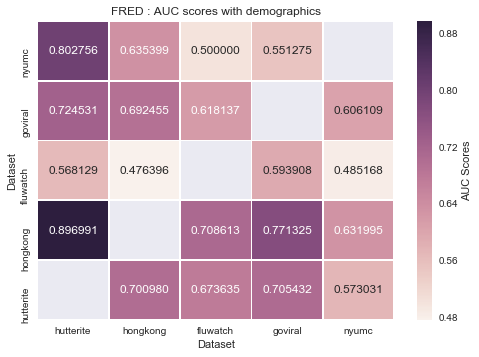

In [30]:
nyumc = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'], 
                     results, 
                     'Dataset',
                     ['hutterite','hongkong','fluwatch','goviral','nyumc'],'AUC Scores','FRED : AUC scores with demographics')

#### Get the distance between the datasets

In [31]:
directory = "../../../Data/with_Improved_Target/With_Demographics/"

In [32]:
data_,columns = get_training_data(files_,directory)

In [33]:
def only_positive_data_stats(data_dict):
    data_stats = defaultdict()
    for i in data_dict.keys():
        data = data_dict[i]
        data = data.loc[data['virus'] == 1]
        data_stats[i] = data.var(axis = 0)
    return data_stats

In [34]:
positive_data_stats = only_positive_data_stats(data_)

In [35]:
#l2 distance
def get_distance(data_stats):

    distance = defaultdict()
    names = list(data_stats)
    for i in names:
        compare_to = [j for j in names if j!=i]
        distance[i] = [(j,np.linalg.norm((np.asarray(data_stats[i]) - np.asarray(data_stats[j])),ord = 2)) for j in compare_to]
    return distance


In [36]:
positive_distance = get_distance(positive_data_stats)

In [37]:
positive_distance

defaultdict(None,
            {'fluwatch': [('nyumc', 0.56014723905669062),
              ('goviral', 0.64451056422949071),
              ('hongkong', 0.41841266237644892),
              ('hutterite', 0.36922323903337906)],
             'goviral': [('nyumc', 0.60523248233044791),
              ('fluwatch', 0.64451056422949071),
              ('hongkong', 0.61349935589774407),
              ('hutterite', 0.5578155626145892)],
             'hongkong': [('nyumc', 0.51544760098981524),
              ('goviral', 0.61349935589774407),
              ('fluwatch', 0.41841266237644892),
              ('hutterite', 0.36774947307054651)],
             'hutterite': [('nyumc', 0.51153969317164172),
              ('goviral', 0.5578155626145892),
              ('fluwatch', 0.36922323903337906),
              ('hongkong', 0.36774947307054651)],
             'nyumc': [('goviral', 0.60523248233044791),
              ('fluwatch', 0.56014723905669062),
              ('hongkong', 0.51544760098981524),
     

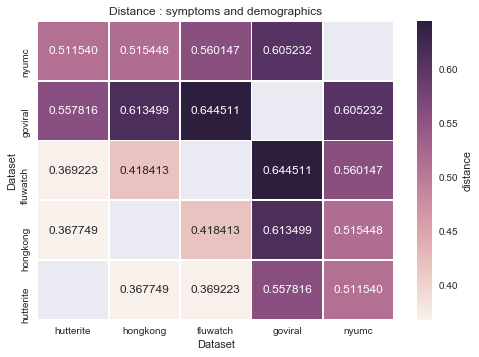

In [38]:
positive_distances = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  positive_distance,
                  'Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'distance',
                  'Distance : symptoms and demographics')